# Taller Binomial

**Métodos Numéricos en Finanzas 2025-I**

*Sarah Daniella Coral Zúñiga*

*Daniel Aragón Urrego*

## Configuración de paquetes del notebook
(por favor correr la siguiente celda para cargar las librerías)

In [1]:
# Instalación de Librerías
!pip install yfinance==0.2.58

# Importación de librerías
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import time
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


## Funciones Auxiliares

(por favor correr la siguiente celda para cargar las funciones auxiliares usadas en este notebook)

In [2]:
# Función auxiliar para impresión legible de los árboles como DataFrame
def imprimir_arbol(nombre, arbol):
    df = pd.DataFrame(arbol)
    df = df.applymap(lambda x: f"{x:.2f}" if not pd.isna(x) else "")
    print(f"\n=== Árbol: {nombre} ===\n")
    print(df)

## Implementación de Modelos

Cada una de las celdas a continuación corresponde a la implementación de un modelo de valoración como función en python. Los modelos implementados son:


*   Modelo Binomial (Cox-Ross-Rubinstein)
*   Modelo Binomial de Jarrow-Rudd
*   Modelo Trinomial
*   Modelo de Black-Scholes



Al final de esta sección hay una celda que verifica el correcto funcionamiento de las implementaciones dados parámetros a modo de ejemplo.

### Modelo Binomial

In [3]:
def binomial_crr(S0, K, T, r, sigma, N, option='call', values=False):
    """
    Implementa el enfoque binomial para construir el árbol del precio del subyacente y
    de las opciones europeas Call y Put bajo el Modelo Cox-Ross-Rubinstein (CRR).
    Calcula u, d y p

    Parámetros:
    ----------
    S0 : Precio inicial del activo subyacente (float).
    K :  Precio de ejercicio de la opción (float).
    T :  Tiempo hasta el vencimiento de la opción (en años) (float).
    r :  Tasa de interés libre de riesgo anual (float).
    sigma : Volatilidad anualizada del activo subyacente (float).
    N : Número de pasos en el árbol binomial (int).
    option : Tipo de opción a valorar ('call' o 'put'). Por defecto es 'call' (str), opcional

    Retorna:
    --------
    3 objetos:
        - float: Valor de la opción en el tiempo 0.
        - np.ndarray: Árbol de precios del activo subyacente.
        - np.ndarray: Árbol de la opción.

    Ejemplo:
    --------
    valor_opcion, arbol_stock, arbol_opcion = binomial_crr(S0=100, K=100, T=1, r=0.05, sigma=0.2, N=100, option='call')
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Árboles: filas = niveles (número de caídas), columnas = pasos de tiempo
    stock_tree = np.full((N+1, N+1), np.nan)
    option_tree = np.full((N+1, N+1), np.nan)

    # Construcción del árbol del subyacente
    for j in range(N+1):         # j es el paso de tiempo (columna)
        for i in range(j+1):     # i es el número de descensos
            stock_tree[i, j] = S0 * (u ** (j - i)) * (d ** i)

    # Valoración en el tiempo T
    for i in range(N+1):
        if option == 'call':
            option_tree[i, N] = max(0, stock_tree[i, N] - K)
        else:
            option_tree[i, N] = max(0, K - stock_tree[i, N])

    # Inducción hacia atrás
    for j in range(N-1, -1, -1):   # columnas de derecha a izquierda
        for i in range(j+1):       # filas
            option_tree[i, j] = np.exp(-r * dt) * (
                p * option_tree[i, j+1] + (1 - p) * option_tree[i+1, j+1]
            )

    if values:
      return option_tree[0,0], stock_tree, option_tree, u, d, p
    else:
      return option_tree[0,0], stock_tree, option_tree

### Modelo Binomial de Jarrow-Rudd

In [4]:
def binomial_jr(S0, K, T, r, sigma, N, option='call', values=False):
    """
    Implementa el enfoque binomial para construir el árbol del precio del subyacente y
    de las opciones europeas Call y Put bajo el Modelo Cox-Ross-Rubinstein (CRR).
    Calcula u, d y p

    Parámetros:
    ----------
    S0 : Precio inicial del activo subyacente (float).
    K :  Precio de ejercicio de la opción (float).
    T :  Tiempo hasta el vencimiento de la opción (en años) (float).
    r :  Tasa de interés libre de riesgo anual (float).
    sigma : Volatilidad anualizada del activo subyacente (float).
    N : Número de pasos en el árbol binomial (int).
    option : Tipo de opción a valorar ('call' o 'put'). Por defecto es 'call' (str), opcional

    Retorna:
    --------
    3 objetos:
        - float: Valor de la opción en el tiempo 0.
        - np.ndarray: Árbol de precios del activo subyacente.
        - np.ndarray: Árbol de la opción.

    Ejemplo:
    --------
    valor_opcion, arbol_stock, arbol_opcion = binomial_jr(S0=100, K=100, T=1, r=0.05, sigma=0.2, N=100, option='call')
    """
    dt = T / N
    u = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.full((N+1, N+1), np.nan)
    option_tree = np.full((N+1, N+1), np.nan)

    for j in range(N+1):
        for i in range(j+1):
            stock_tree[i, j] = S0 * (u**(j - i)) * (d**i)

    for i in range(N+1):
        ST = stock_tree[i, N]
        option_tree[i, N] = max(0, ST - K) if option == 'call' else max(0, K - ST)

    for j in range(N-1, -1, -1):
        for i in range(j+1):
            option_tree[i, j] = np.exp(-r * dt) * (
                p * option_tree[i, j+1] + (1 - p) * option_tree[i+1, j+1]
            )

    if values:
      return option_tree[0,0], stock_tree, option_tree, u, d, p
    else:
      return option_tree[0,0], stock_tree, option_tree

### Modelo Trinomial

In [5]:
def trinomial_eur(S0, K, T, r, sigma, N, option='call', values=False):
    """
    Árbol trinomial para opciones europeas.

    Parámetros:
    S0: Precio inicial del activo subyacente
    K: Precio de ejercicio (strike)
    T: Tiempo hasta el vencimiento (en años)
    r: Tasa libre de riesgo
    sigma: Volatilidad
    N: Número de pasos en el árbol
    option: 'call' o 'put'

    Retorna:
    Valor de la opción, árbol del subyacente y árbol de la opción
    """
    dt = T / N
    u = np.exp( sigma * np.sqrt( 2 * dt))
    d = 1 / u
    m = 1

    # Probabilidades neutrales al riesgo
    val1 = np.exp( 0.5 * r * dt)
    val2 = np.exp( sigma * np.sqrt( 0.5 * dt))
    pu = ((val1 - ( 1 / val2)) / (val2 - ( 1 / val2)))**2
    pd = ((val2 - val1) / (val2 - ( 1 / val2)))**2
    pm = 1 - pu - pd  # se asegura que sumen 1

    if not (0 <= pu <= 1 and 0 <= pm <= 1 and 0 <= pd <= 1):
        raise ValueError("Probabilidades no válidas. Intente ajustar N o sigma.")

    # Árbol de precios del subyacente
    stock_tree = [[0.0 for _ in range(N + 1)] for _ in range(2*N + 1)]

    for j in range(N + 1):    # j es el paso de tiempo (columna)
      for i in range(2*j + 1):    # i es el número de descensos
        stock_tree[i][j] = S0 * (u **j) * (d ** i)


    # Inicializar arbol de opciones
    option_tree = [[0.0 for _ in row] for row in stock_tree]

    # Valoración en el tiempo T
    for i in range(2*N + 1):
        if option == 'call':
            option_tree[i][N] = max(0, stock_tree[i][N] - K)
        elif option == 'put':
            option_tree[i][N] = max(0, K - stock_tree[i][N])
        else:
          raise ValueError("option debe ser 'call' o 'put'")

    # Inducción hacia atrás
    for j in range(N-1, -1, -1):   # columnas de derecha a izquierda
        for i in range(2*j + 1):       # filas
            option_tree[i][j] = np.exp(-r * dt) * (
                pu * option_tree[i][j+1] + pm * option_tree[i + 1][j+1] + pd * option_tree[i +2][j+1]
            )

    if values:
      return option_tree[0][0], stock_tree, option_tree, u, d, pu, pd, pm
    else:
      return option_tree[0][0], stock_tree, option_tree


### Modelo de Black-Scholes

In [6]:
def black_scholes(S0, K, T, r, sigma, option='call'):
    """
    Implementa el modelo Black-Scholes para valoración de opciones Call y Put europeas

    Parámetros:
    ----------
    S0: Precio actual del activo subyacente (float).
    K: Precio de ejercicio de la opción (float).
    T: Tiempo hasta el vencimiento de la opción (en años) (float).
    r: Tasa de interés libre de riesgo anual (float).
    sigma: Volatilidad anualizada del activo subyacente (float).
    option: Tipo de opción a valorar ('call' o 'put'). Por defecto es 'call' (str), opcional

    Retorna:
    --------
    float: Precio de la opción calculado según el modelo Black-Scholes.

    Ejemplo:
    --------
    precio_opcion = black_scholes(S=100, K=100, T=1, r=0.05, sigma=0.2, option='call')
    """
    # Calcular d1 y d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option == 'call':
        precio = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        precio = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

    return precio


### Ejemplos de uso

In [7]:
# Ejemplo de uso opcion Call

# Parámetros
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 4

# Llamada a las funciones
call_prima_crr, arbol_suby_crr, arbol_call_crr = binomial_crr(S0, K, T, r, sigma, N, option='call')
call_prima_jr, arbol_suby_jr, arbol_call_jr = binomial_jr(S0, K, T, r, sigma, N, option='call')
call_prima_tri, arbol_suby_tri, arbol_call_tri = trinomial_eur(S0, K, T, r, sigma, N, option='call')
call_prima_bs = black_scholes(S0, K, T, r, sigma, option='call')

# Impresión de resultado: árbol del subyacente y árbol de la call (si aplican) y prima modelo CRR
print('Resultados modelo binomial Cox-Ross-Rubenstein')
print(f'El árbol del subyacente es:')
print(f'{pd.DataFrame(arbol_suby_crr).fillna("-")}')
print()
print(f'El árbol de la opción Call Europea:')
print(f'{pd.DataFrame(arbol_call_crr).fillna("-")}')
print(f'La prima de la opción Call Europea es {call_prima_crr.round(2)} dólares')
print()

# Impresión de resultado: árbol del subyacente y árbol de la call (si aplican) y prima modelo Jarrow-Rudd
print('Resultados modelo binomial Jarrow-Rudd')
print(f'El árbol del subyacente es:')
print(f'{pd.DataFrame(arbol_suby_jr).fillna("-")}')
print()
print(f'El árbol de la opción Call Europea:')
print(f'{pd.DataFrame(arbol_call_jr).fillna("-")}')
print(f'La prima de la opción Call Europea es {call_prima_jr.round(2)} dólares')
print()

# Impresión de resultado: árbol del subyacente y árbol de la call (si aplican) y prima
print(f'Resultados modelo Trinomial')
print(f'El árbol del subyacente es:')
print(f'{pd.DataFrame(arbol_suby_tri).fillna("-")}')
print()
print(f'El árbol de la opción Call Europea:')
print(f'{pd.DataFrame(arbol_call_tri).fillna("-")}')
print(f'La prima de la opción Call Europea es {call_prima_tri.round(2)} dólares')
print()

# Impresión de resultado: árbol del subyacente y árbol de la call (si aplican) y prima
print('Resultados modelo Black-Scholes')
print(f'La prima de la opción Call Europea es {call_prima_bs.round(2)} dólares')

Resultados modelo binomial Cox-Ross-Rubenstein
El árbol del subyacente es:
       0           1           2           3           4
0  100.0  110.517092  122.140276  134.985881  149.182470
1      -   90.483742       100.0  110.517092  122.140276
2      -           -   81.873075   90.483742  100.000000
3      -           -           -   74.081822   81.873075
4      -           -           -           -   67.032005

El árbol de la opción Call Europea:
          0          1          2          3          4
0  9.970523  15.921519  24.609285  36.228101  49.182470
1         -   3.317261   6.245695  11.759312  22.140276
2         -          -        0.0        0.0   0.000000
3         -          -          -        0.0   0.000000
4         -          -          -          -   0.000000
La prima de la opción Call Europea es 9.97 dólares

Resultados modelo binomial Jarrow-Rudd
El árbol del subyacente es:
       0           1           2           3           4
0  100.0  111.349086   123.98619  

## Calibración a SPY

### Descarga de precios históricos diarios de SPY desde Yahoo Finance usando `yfinance`.

In [8]:
## funcion para descargar precios usando yfinance y calculo de retornos continuos
def obtener_precios(activo,inicio,fin,periodicidad):
  precios = yf.download(activo,inicio,fin,periodicidad)['Close']
  retornos = np.log(precios).diff().dropna()
  return precios, retornos

In [9]:
## Se obtienen los precios y retornos diarios sobre el ETF SPY
precios, retornos = obtener_precios('SPY',"2022-01-01", "2025-04-30",'1d')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### Calibración de $\sigma$ (volatilidad histórica) y determinación de una tasa libre de riesgo *r*.

In [10]:
## Se establecen los datos de entrada y se calibran parametros

# precio spot (ultimo precio conocido)
S0 =precios.values[-1,-1]
# tasa libre de riesgo: rendimiento del bono del tesoro a 1 año y se convierte la tasa
r = np.log(1 + 0.0392)
# Tiempo al vencimiento en años
T = 1

# A partir de los retornos se calcula la volatilidad diaria y anualizada
sigma_d = retornos.std()[0]  # Volatilidad diaria
sigma = sigma_d * np.sqrt(252)  # Volatilidad anualizada

print(f'S0: {S0:.2f} r: {r:.2f} T:{T:.2f} sigma: {sigma:.2f}')

S0: 554.32 r: 0.04 T:1.00 sigma: 0.19


### Cálculo de *u*, *d* y *p* bajo los modelos CRR y Jarrow-Rudd

In [11]:
K = S0 * 1.1
N = 252
u_crr, d_crr, p_crr = binomial_crr(S0, K, T, r, sigma, N, option='call', values=True)[-3:]

u_jr, d_jr, p_jr = binomial_jr(S0, K, T, r, sigma, N, option='call', values=True)[-3:]

print(f"Modelo CRR\n u: {u_crr}, d: {d_crr}, p:{p_crr}")
print(f"Modelo Jarrow-Rudd\n u: {u_jr}, d: {d_jr}, p:{p_jr}")

Modelo CRR
 u: 1.0120506948833936, d: 0.9880927952084633, p:0.5033746976831878
Modelo Jarrow-Rudd
 u: 1.01213251225205, d: 0.9881726757449829, p:0.5000000716173107


## Verificación de la estabilidad al variar N y análisis de convergencia hacia el modelo de Black-Scholes

In [12]:
K = S0 * 1.1 # Strike a la subida de 10% del precio
T = 1 # Vencimiento al año
N_list = [int(30*(i)) for i in range(1,21)] # se crea una lista con 20 valores para particiones o pasos en el árbol

# Se crea una lista vacia para almacenar los resultados de valorar opciones para diferentes strikes, vencimientos y pasos
resultados = []
inicio = time.time()

for N in N_list:
    # valoracion usando arbol binomial con modelo CRR
    call_bin_crr, stock_tree, call_tree = binomial_crr(S0, K, T, r, sigma, N, option='call')
    put_bin_crr, _, put_tree = binomial_crr(S0, K, T, r, sigma, N, option='put')
    # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
    paridad_b_crr = call_bin_crr - put_bin_crr - S0 + K * np.exp(-r * T)

    # valoracion usando arbol binomial con modelo Jarrow-Rudd
    call_bin_jr, stock_tree_jr, call_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='call')
    put_bin_jr, _, put_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='put')
    # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
    paridad_b_jr = call_bin_jr - put_bin_jr - S0 + K * np.exp(-r * T)

    # valoracion utilizando la fórmula de Black-Scholes.
    call_bs = black_scholes(S0, K, T, r, sigma, option='call')
    put_bs = black_scholes(S0, K, T, r, sigma, option='put')
    # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
    paridad_bs = call_bs - put_bs - S0 + K * np.exp(-r * T)

    resultados.append({
        'N': N,
        'Call CRR': round(call_bin_crr, 4),
        'Call Jarrow-Rudd': round(call_bin_jr, 4),
        'Call Black-Scholes': round(call_bs, 4),

        'Put CRR': round(put_bin_crr, 4),
        'Put Jarrow-Rudd': round(put_bin_jr, 4),
        'Put Black-Scholes': round(put_bs, 4)
    })

# Mostrar resultados
fin = time.time()
tabla = pd.DataFrame(resultados)
print(f"\nTiempo total de ejecución: {fin - inicio:.2f} segundos")
print(f"\nResumen de Resultados: (para Strike = {K:.0f} y Vencimiento = {T} año)")
tabla.sort_values(by='N')


Tiempo total de ejecución: 27.47 segundos

Resumen de Resultados: (para Strike = 610 y Vencimiento = 1 año)


,N,Call CRR,Call Jarrow-Rudd,Call Black-Scholes,Put CRR,Put Jarrow-Rudd,Put Black-Scholes
0,30,29.1394,28.7326,28.9119,61.5708,61.1639,61.3433
1,60,28.7843,29.0682,28.9119,61.2156,61.4996,61.3433
2,90,28.9893,28.8929,28.9119,61.4207,61.3242,61.3433
3,120,28.9408,28.9089,28.9119,61.3722,61.3403,61.3433
4,150,28.8648,28.9700,28.9119,61.2961,61.4014,61.3433
5,180,28.9489,28.9551,28.9119,61.3802,61.3864,61.3433
6,210,28.9449,28.9075,28.9119,61.3763,61.3388,61.3433
7,240,28.8966,28.8821,28.9119,61.3279,61.3135,61.3433
8,270,28.8978,28.9253,28.9119,61.3291,61.3567,61.3433
9,300,28.9324,28.9410,28.9119,61.3637,61.3723,61.3433


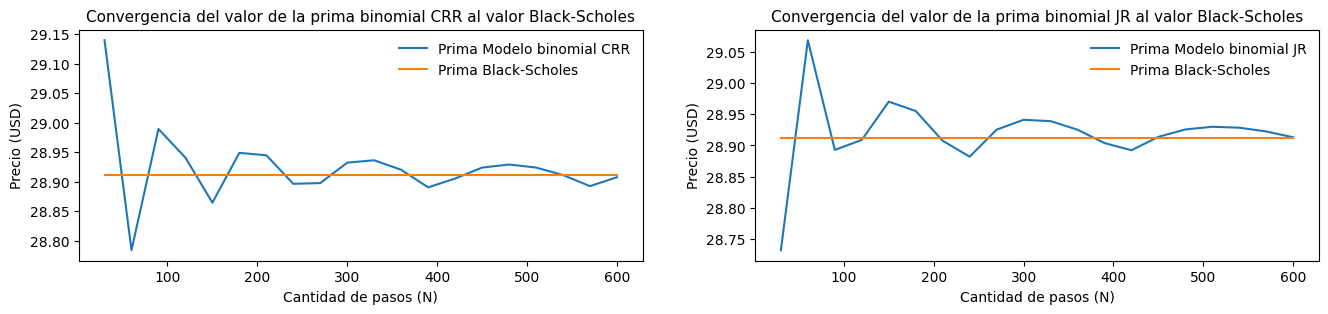

In [13]:
# Convergencia del valor de la prima del modelo binomial al resultado Black-Scholes
fig, ax = plt.subplots(1,2, figsize=(16,3))
# modelo binomial CRR
ax[0].plot(tabla['N'], tabla['Call CRR'], label='Prima Modelo binomial CRR')
ax[0].plot(tabla['N'], tabla['Call Black-Scholes'], label='Prima Black-Scholes')
ax[0].set_title('Convergencia del valor de la prima binomial CRR al valor Black-Scholes', fontsize=11)
ax[0].set_xlabel('Cantidad de pasos (N)')
ax[0].set_ylabel('Precio (USD)')
ax[0].legend(frameon=False, fontsize=10)

# modelo binomial Jarrow-Rudd
ax[1].plot(tabla['N'], tabla['Call Jarrow-Rudd'], label='Prima Modelo binomial JR')
ax[1].plot(tabla['N'], tabla['Call Black-Scholes'], label='Prima Black-Scholes')
ax[1].set_title('Convergencia del valor de la prima binomial JR al valor Black-Scholes', fontsize=11)
ax[1].set_xlabel('Cantidad de pasos (N)')
ax[1].set_ylabel('Precio (USD)')
ax[1].legend(frameon=False, fontsize=10)
plt.savefig('convergencia.png')
plt.show()

## Valoración de Opciones Europeas

Se presenta una tabla comparativa entre modelos para valoraciones de opciones tipo call y put europeas en distintos strikes y vencimientos.

In [14]:
K_list = [0.75 * S0, 0.9 * S0, S0, S0 * 1.1, 1.25 * S0] # se crea una lista con 5 strikes
T_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5] # se crea una lista con 6 vencimientos
N = 400

# Se crea una lista vacia para almacenar los resultados de valorar opciones para diferentes strikes, vencimientos y pasos
resultados = []
inicio = time.time()

for T in T_list:
    for K in K_list:
        # valoracion usando arbol binomial con modelo CRR
        call_bin_crr, stock_tree, call_tree = binomial_crr(S0, K, T, r, sigma, N, option='call')
        put_bin_crr, _, put_tree = binomial_crr(S0, K, T, r, sigma, N, option='put')
        # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
        paridad_b_crr = call_bin_crr - put_bin_crr - S0 + K * np.exp(-r * T)

        # valoracion usando arbol binomial con modelo Jarrow-Rudd
        call_bin_jr, stock_tree_jr, call_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='call')
        put_bin_jr, _, put_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='put')
        # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
        paridad_b_jr = call_bin_jr - put_bin_jr - S0 + K * np.exp(-r * T)

        # valoracion utilizando la fórmula de Black-Scholes.
        call_bs = black_scholes(S0, K, T, r, sigma, option='call')
        put_bs = black_scholes(S0, K, T, r, sigma, option='put')
        # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
        paridad_bs = call_bs - put_bs - S0 + K * np.exp(-r * T)

        # label = f"K={round(K, 2)}, T={T}, N={N}"

        # imprimir_arbol(f"Subyacente CRR - {label}", stock_tree)
        # imprimir_arbol(f"Call CRR      - {label}", call_tree)
        # imprimir_arbol(f"Put CRR      - {label}", put_tree)

        # imprimir_arbol(f"Subyacente JR - {label}", stock_tree_jr)
        # imprimir_arbol(f"Call JR      - {label}", call_tree_jr)
        # imprimir_arbol(f"Put JR      - {label}", put_tree_jr)

        resultados.append({
            'Strike': round(K, 2),
            'Vencimiento': T,

            'Call CRR': round(call_bin_crr, 4),
            'Call Jarrow-Rudd': round(call_bin_jr, 4),
            'Call Black-Scholes': round(call_bs, 4),

            'Put CRR': round(put_bin_crr, 4),
            'Put Jarrow-Rudd': round(put_bin_jr, 4),
            'Put Black-Scholes': round(put_bs, 4)
        })

            #input("\nPresiona Enter para continuar...\n")

# Mostrar resultados
fin = time.time()
tabla = pd.DataFrame(resultados)
print(f"\nTiempo total de ejecución: {fin - inicio:.2f} segundos")
print(f"\nNúmero de pasos para modelos binomiales: {N} pasos")
print("\nResumen de Resultados:")
tabla.sort_values(by='Strike')


Tiempo total de ejecución: 31.96 segundos

Número de pasos para modelos binomiales: 400 pasos

Resumen de Resultados:


,Strike,Vencimiento,Call CRR,Call Jarrow-Rudd,Call Black-Scholes,Put CRR,Put Jarrow-Rudd,Put Black-Scholes
0,415.74,0.25,142.5681,142.5681,142.5683,0.0108,0.0108,0.0110
5,415.74,0.50,146.7419,146.7406,146.7424,0.2454,0.2441,0.2459
15,415.74,1.00,155.8315,155.8325,155.8353,1.5692,1.5702,1.5730
10,415.74,0.75,151.2096,151.2088,151.2092,0.8116,0.8107,0.8112
25,415.74,1.50,165.1773,165.1759,165.1735,3.2972,3.2958,3.2933
20,415.74,1.25,160.5148,160.5108,160.5110,2.4253,2.4213,2.4215
6,498.89,0.50,71.6196,71.6283,71.6200,6.6878,6.6964,6.6882
11,498.89,0.75,79.6000,79.5967,79.5877,9.9864,9.9830,9.9740
16,498.89,1.00,86.9618,86.9595,86.9449,12.7110,12.7088,12.6942
21,498.89,1.25,93.8108,93.8242,93.8258,14.9674,14.9808,14.9824


### Visualización de la correspondencia entre primas y distintos strikes y vencimientos:

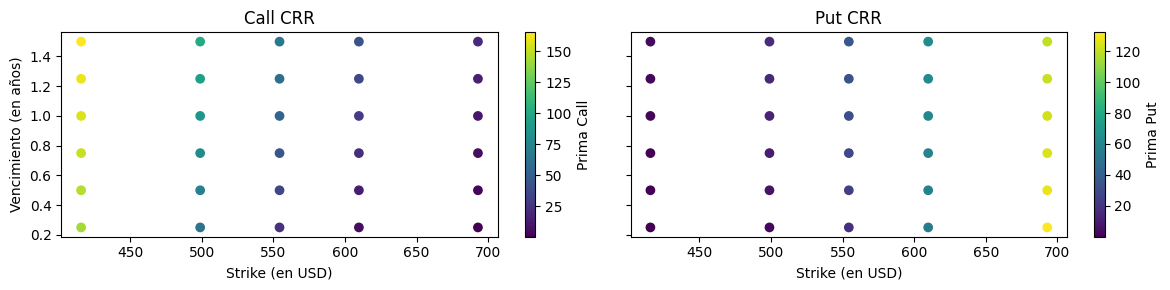

In [15]:
# Crear gráficos juntos
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)

# Plot para Calls
scatter_a = axes[0].scatter(tabla['Strike'], tabla['Vencimiento'], c=tabla['Call CRR'], cmap='viridis')
axes[0].set_title('Call CRR')
axes[0].set_xlabel('Strike (en USD)')
axes[0].set_ylabel('Vencimiento (en años)')
cbar_a = fig.colorbar(scatter_a, ax=axes[0])
cbar_a.set_label('Prima Call')

# Plot para Puts
scatter_b = axes[1].scatter(tabla['Strike'], tabla['Vencimiento'], c=tabla['Put CRR'], cmap='viridis')
axes[1].set_title('Put CRR')
axes[1].set_xlabel('Strike (en USD)')
cbar_b = fig.colorbar(scatter_b, ax=axes[1])
cbar_b.set_label('Prima Put')

plt.tight_layout()
plt.show()

### Verificación de la paridad call-put: $C − P = S − Ke^{−rT}$


In [16]:
# Verificación de la paridad call-put:
K = S0 * 1.1
T = 1
N_list = [4, 12, 252] # se crea una lista con 3 valores para particiones o pasos en el árbol

# Se crea una lista vacia para almacenar los resultados de valorar opciones para diferentes strikes, vencimientos y pasos
resultados = [[],[],[]]

inicio = time.time()

n = 0
while n < len(N_list):
  resultados[n].extend([{'Modelo': 'Binomial'}, {'Modelo': 'Jarrow-Rudd'}, {'Modelo': 'Black Scholes'}])
  n += 1
n = 0
while n < len(resultados):
  N = N_list[n]
  # valoracion usando arbol binomial con modelo CRR
  call_bin_crr, stock_tree, call_tree = binomial_crr(S0, K, T, r, sigma, N, option='call')
  put_bin_crr, _, put_tree = binomial_crr(S0, K, T, r, sigma, N, option='put')
  # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
  paridad_b_crr = call_bin_crr - put_bin_crr - S0 + K * np.exp(-r * T)

  # valoracion usando arbol binomial con modelo Jarrow-Rudd
  call_bin_jr, stock_tree_jr, call_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='call')
  put_bin_jr, _, put_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='put')
  # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
  paridad_b_jr = call_bin_jr - put_bin_jr - S0 + K * np.exp(-r * T)

  # valoracion utilizando la fórmula de Black-Scholes.
  call_bs = black_scholes(S0, K, T, r, sigma, option='call')
  put_bs = black_scholes(S0, K, T, r, sigma, option='put')
  # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
  paridad_bs = call_bs - put_bs - S0 + K * np.exp(-r * T)

  resultados[n][0].update({'Call': round(call_bin_crr, 4), 'Put': round(put_bin_crr, 4), 'Paridad': round(paridad_b_crr, 12)})
  resultados[n][1].update({'Call': round(call_bin_jr, 4), 'Put': round(put_bin_jr, 4), 'Paridad': round(paridad_b_jr, 12)})
  resultados[n][2].update({'Call': round(call_bs, 4), 'Put': round(put_bs, 4), 'Paridad': round(paridad_bs, 12)})
  n += 1

# Mostrar resultados
fin = time.time()
tablas = []
for i in range(len(resultados)):
  tablas.append(pd.DataFrame(resultados[i]))

print(f"\nTiempo total de ejecución: {fin - inicio:.2f} segundos")
print(f"\nResumen de Resultados: (para Strike = {K:.0f} y Vencimiento = {T} años)")
print("\nN = 4")
display(tablas[0])
print("\nN = 12")
display(tablas[1])
print("\nN = 252")
display(tablas[2])


Tiempo total de ejecución: 0.37 segundos

Resumen de Resultados: (para Strike = 610 y Vencimiento = 1 años)

N = 4


,Modelo,Call,Put,Paridad
0,Binomial,31.0842,63.5155,0.0
1,Jarrow-Rudd,31.0160,63.4474,0.0
2,Black Scholes,28.9119,61.3433,0.0



N = 12


,Modelo,Call,Put,Paridad
0,Binomial,28.6997,61.1310,0.0
1,Jarrow-Rudd,29.5003,61.9316,0.0
2,Black Scholes,28.9119,61.3433,0.0



N = 252


,Modelo,Call,Put,Paridad
0,Binomial,28.8701,61.3014,3.000000e-12
1,Jarrow-Rudd,28.9036,61.3349,3.000000e-12
2,Black Scholes,28.9119,61.3433,0.000000e+00


## Valoración de Opciones Americanas



### Algoritmo de inducción hacia atrás modificado para permitir ejercicio anticipado.

In [17]:
def binomial_crr_americana(S0, K, T, r, sigma, N, option='call'):
    """
    Implementa el modelo binomal CRR para obtener el precio de una opción americana (call o put),
    es decir, permite el ejercicio anticipado de la opción en cualquier momento antes del vencimiento.

    Parámetros:
    ----------

    S0: Precio actual del activo subyacente (float).
    K: Precio de ejercicio de la opción (float).
    T: Tiempo hasta el vencimiento de la opción (en años) (float).
    r: Tasa de interés libre de riesgo anual (float).
    sigma: Volatilidad anualizada del activo subyacente (float).
    option: Tipo de opción a valorar ('call' o 'put'). Por defecto es 'call' (str), opcional

    Retorna:
    --------
        - float: Valor de la opción en el tiempo 0.
        - np.ndarray: Árbol de precios del activo subyacente.
        - np.ndarray: Árbol de valores de la opción.

    Ejemplo:
    --------
    valor_opcion, arbol_stock, arbol_opcion = binomial_crr_americana(S0=100, K=100, T=1, r=0.05, sigma=0.2, N=100, option='call')
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))  #factor de alza
    d = 1 / u # factor de baja
    p = (np.exp(r * dt) - d) / (u - d) # probabilidad riesgo neutral

    # creación de los objetos para almacenar los valores de los árboles de subyacente y opciones Call o Put
    stock_tree = np.full((N+1, N+1), np.nan)
    option_tree = np.full((N+1, N+1), np.nan)

    # Construcción del árbol del subyacente
    for j in range(N+1):
        for i in range(j+1):
            stock_tree[i, j] = S0 * (u**(j - i)) * (d**i)

    # valoración en tiempo T (Call o Put)
    for i in range(N+1):
        ST = stock_tree[i, N]
        option_tree[i, N] = max(0, ST - K) if option == 'call' else max(0, K - ST)

    # inducción hacia atrás en el árbol del derivado permitiendo el ejercicio anticipado. Comparar el valor de ejercer o esperar
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            hold = np.exp(-r * dt) * (p * option_tree[i, j+1] + (1 - p) * option_tree[i+1, j+1])
            early_exercise = max(0, stock_tree[i, j] - K) if option == 'call' else max(0, K - stock_tree[i, j])
            option_tree[i, j] = max(hold, early_exercise)

    return option_tree[0, 0], stock_tree, option_tree

### Comparación del precio de opciones americanas con sus equivalentes europeas.

In [18]:
# Comparar con opciones europeas
precio_call_europea, _, _ = binomial_crr(S0, K, T, r, sigma, N, option='call')
precio_call_americana, _, _ = binomial_crr_americana(S0, K, T, r, sigma, N, option='call')

print(f"Call Europea: {precio_call_europea:.4f}, Call Americana: {precio_call_americana:.4f}")
print(f"Diferencia: {precio_call_americana - precio_call_europea:.4f}")

print('Conclusión: Para el caso de opciones que no pagan dividendos, no es óptimo ejercer la opción call americana antes del vencimiento')
print()
precio_put_europea, _, _ = binomial_crr(S0, K, T, r, sigma, N, option='put')
precio_put_americana, _, _ = binomial_crr_americana(S0, K, T, r, sigma, N, option='put')

print(f"Put Europea: {precio_put_europea:.4f}, Put Americana: {precio_put_americana:.4f}")
print(f"Diferencia: {precio_put_americana - precio_put_europea:.4f}")
print(f'Conclusión: Existe un incentivo para ejercer la opción Put americana antes del vencimiento, lo cual se refleja en una prima más alta con respecto a la opción europea.')

Call Europea: 28.8701, Call Americana: 28.8701
Diferencia: 0.0000
Conclusión: Para el caso de opciones que no pagan dividendos, no es óptimo ejercer la opción call americana antes del vencimiento

Put Europea: 61.3014, Put Americana: 66.7567
Diferencia: 5.4552
Conclusión: Existe un incentivo para ejercer la opción Put americana antes del vencimiento, lo cual se refleja en una prima más alta con respecto a la opción europea.


## Valoración Opciones Exóticas


### Implementación del algoritmo de inducción hacia atrás para opciones con barreras knock-in y knock-out

In [19]:
def binomial_barrier(S0, K, T, r, sigma, N, barrier, B, option='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.full((N+1, N+1), np.nan)
    option_tree = np.full((N+1, N+1), 0.0)
    barrier_tree = np.full((N+1, N+1), False)

    for j in range(N+1):
        for i in range(j+1):
            S = S0 * (u ** (j - i)) * (d ** i)
            stock_tree[i, j] = S

            # Revisar si se activa o anula la opción
            if 'up' in barrier:
                crossed = S >= B
            else:  # 'down'
                crossed = S <= B

            # Knock-in: se activa si cruzó la barrera en cualquier momento
            # Knock-out: se anula si cruzó la barrera
            barrier_tree[i, j] = crossed

    # Payoff en el vencimiento
    for i in range(N+1):
        S = stock_tree[i, N]
        crossed = np.any(barrier_tree[:i+1, :N+1]) if 'in' in barrier else not np.any(barrier_tree[:i+1, :N+1])
        if crossed:
            option_tree[i, N] = max(0, S - K) if option == 'call' else max(0, K - S)

    # Inducción hacia atrás
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            crossed = np.any(barrier_tree[:i+1, :j+2]) if 'in' in barrier else not np.any(barrier_tree[:i+1, :j+2])
            if crossed:
                option_tree[i, j] = np.exp(-r * dt) * (
                    p * option_tree[i, j+1] + (1 - p) * option_tree[i+1, j+1])
            else:
                option_tree[i, j] = 0.0

    return option_tree[0, 0], stock_tree, option_tree

### Análisis del efecto de distintas ubicaciones de barreras sobre el precio de la opción.

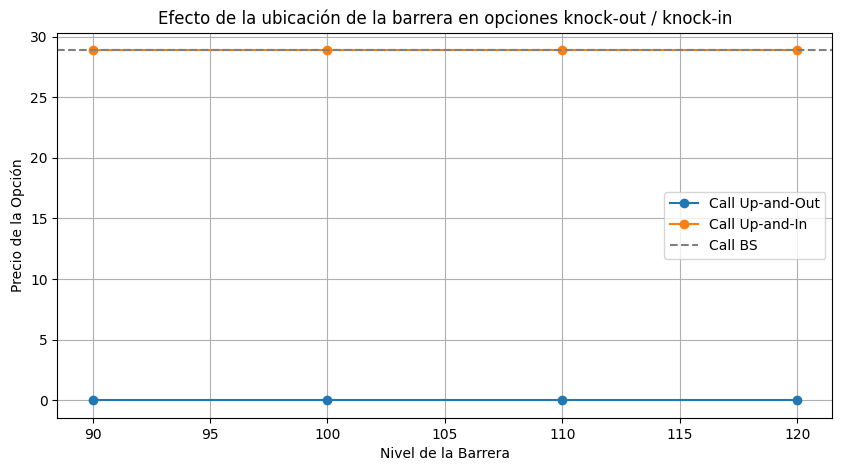

In [20]:
def binomial_barrier(S0, K, T, r, sigma, N, option='call', barrier=None, barrier_type='up-and-out'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Árbol de precios del subyacente
    stock_tree = np.full((N+1, N+1), np.nan)
    option_tree = np.full((N+1, N+1), 0.0)

    for j in range(N+1):
        for i in range(j+1):
            stock_tree[i, j] = S0 * (u**(j - i)) * (d**i)

    # Evaluar si la barrera es alcanzada
    def is_knocked(i, j):
        path_prices = [S0 * (u**(k - m)) * (d**m) for k in range(j+1) for m in range(k+1)]
        if 'up' in barrier_type:
            return max(path_prices) >= barrier
        else:  # down
            return min(path_prices) <= barrier

    # Valor terminal
    for i in range(N+1):
        ST = stock_tree[i, N]
        knocked = (ST >= barrier if 'up' in barrier_type else ST <= barrier)
        valid = not knocked if 'out' in barrier_type else knocked

        if valid:
            option_tree[i, N] = max(0, ST - K) if option == 'call' else max(0, K - ST)

    # Inducción hacia atrás
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            ST = stock_tree[i, j]
            knocked = (ST >= barrier if 'up' in barrier_type else ST <= barrier)
            valid = not knocked if 'out' in barrier_type else knocked

            if valid:
                option_tree[i, j] = np.exp(-r * dt) * (p * option_tree[i, j+1] + (1 - p) * option_tree[i+1, j+1])
            else:
                option_tree[i, j] = 0.0

    return option_tree[0, 0], stock_tree, option_tree

# Distintas ubicaciones de barrera
barreras = [90, 100, 110, 120]
valores_ko = []
valores_ki = []

for B in barreras:
    precio_ko, _, _ = binomial_barrier(S0, K, T, r, sigma, N, option='call', barrier=B, barrier_type='up-and-out')
    precio_ki, _, _ = binomial_barrier(S0, K, T, r, sigma, N, option='call', barrier=B, barrier_type='up-and-in')
    valores_ko.append(precio_ko)
    valores_ki.append(precio_ki)

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(barreras, valores_ko, marker='o', label='Call Up-and-Out')
plt.plot(barreras, valores_ki, marker='o', label='Call Up-and-In')
plt.axhline(y=black_scholes(S0, K, T, r, sigma, 'call'), color='gray', linestyle='--', label='Call BS')
plt.xlabel('Nivel de la Barrera')
plt.ylabel('Precio de la Opción')
plt.title('Efecto de la ubicación de la barrera en opciones knock-out / knock-in')
plt.legend()
plt.grid(True)
plt.show()

## Estrategias con Opciones



### Simulación y valoración de bull call spread, straddle y collar

**Bull Call Spread**: Consiste en comprar una opción call a un precio de ejercicio más bajo (K1) y vender una opción call a un precio de ejercicio más alto (K2), ambas con el mismo vencimiento (T).

$$ \text{Bull Call Spread} = \text{Largo Call}(K_1, T) - \text{Corto Call}(K_2, T), \quad \text{con } K_1 < K_2 $$

**Straddle**: Esta estrategia implica comprar una opción call y una opción put con el mismo precio de ejercicio (Kc) y vencimiento (T).

$$ \text{Straddle} = \text{Largo Call}(K_c, T) + \text{Largo Put}(K_c, T) $$

**Collar**: La estrategia consiste en comprar una opción put con precio de ejercicio *Kp* y vender una opción call con precio de ejercicio *Kc*, , ambas con el mismo vencimiento (T).

$$ \text{Collar} = \text{Largo Put}(K_p, T) - \text{Corto Call}(K_c, T) $$

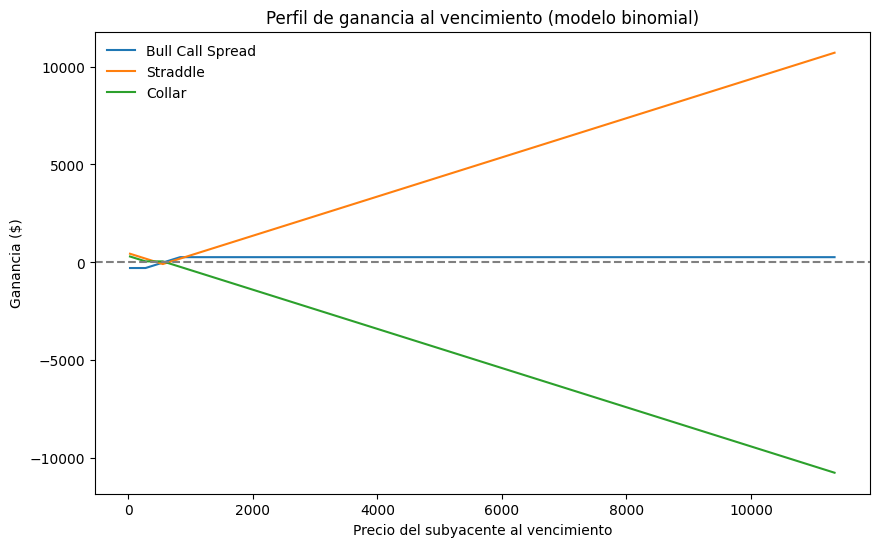

In [21]:
## Se utliza la función del modelo binomial CRR para opciones europeas definida previamente.

# # Parámetros adicionales necesarios

K1 = S0 * 0.5      # Strike bajo
K2 = S0 * 1.5      # Strike alto
Kc = S0            # Strike call (collar)
Kp = S0 * 0.5      # Strike put (collar)

# Calcula el valor de la opción y obtiene el árbol stock_tree
valor_opcion, stock_tree, option_tree = binomial_crr(S0, K1, T, r, sigma, N, 'call')

# Extrae precios al vencimiento del árbol del subyacente (última columna stock_tree)
ST = stock_tree[:N+1, N]  # Precios del activo al vencimiento

# Define las funciones de payoff igual que antes
def bull_call_spread_payoff(ST):
    return np.maximum(ST - K1, 0) - np.maximum(ST - K2, 0)

def straddle_payoff(ST):
    return np.maximum(ST - S0, 0) + np.maximum(S0 - ST, 0)

def collar_payoff(ST):
    return np.maximum(Kp - ST, 0) - np.maximum(ST - Kc, 0)

# Calcula los costos de las estrategias usando binomial_crr para cada strike
call_low = binomial_crr(S0, K1, T, r, sigma, N, 'call')[0]
call_high = binomial_crr(S0, K2, T, r, sigma, N, 'call')[0]
spread_cost = call_low - call_high

straddle_call = binomial_crr(S0, S0, T, r, sigma, N, 'call')[0]
straddle_put = binomial_crr(S0, S0, T, r, sigma, N, 'put')[0]
straddle_cost = straddle_call + straddle_put

collar_put = binomial_crr(S0, Kp, T, r, sigma, N, 'put')[0]
collar_call = binomial_crr(S0, Kc, T, r, sigma, N, 'call')[0]
collar_cost = collar_put - collar_call

# Calcula los payoffs ajustados por el costo
bull_call = bull_call_spread_payoff(ST) - spread_cost
straddle = straddle_payoff(ST) - straddle_cost
collar = collar_payoff(ST) - collar_cost

plt.figure(figsize=(10, 6))
plt.plot(ST, bull_call, label='Bull Call Spread')
plt.plot(ST, straddle, label='Straddle')
plt.plot(ST, collar, label='Collar')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Perfil de ganancia al vencimiento (modelo binomial)')
plt.xlabel('Precio del subyacente al vencimiento')
plt.ylabel('Ganancia ($)')
plt.legend(frameon=False)
plt.grid(False)
plt.savefig('estrategias.png')
plt.show()


### Interpretación de las ventajas y desventajas de cada estrategia frente a distintos escenarios de mercado.

Con respecto a la estrategia **Bull Call Spread**, está orientada a mercados alcistas, buscando maximizar la diferencia entre el strike de la opción comprada y la opción vendidas. Así, el inversionista puede ganar cuando el precio del activo supera el precio de ejercicio de la opción comprada, aunque el beneficio es limitado porque depende de la diferencia entre los precios de ejercicio de las opciones involucradas.

En el caso del **Straddle**, es una estrategia que se aplica en mercados con alta volatilidad, lo cual resalta su ventaja de generar ganancias cuando el precio del activo cambia significativamente en cualquier dirección. Sin embargo, implementar esta estrategia requiere comprar tanto la opción Call como Put, por lo cual, el pago de las dos primas representa una desventaja. A esto se suma que la estrategia tiene el riesgo de no generar el resultado esperado si el precio mantiene estable (mercado lateral).

Finalmente, para la estrategia **Collar**, útil en mercados bajistas, tiene como objetivo protegerse contra caídas en el precio del subyacente, minimizando el costo al vender una opción call. Sin embargo, el beneficio de la estrategia es limitado en mercado alcistas.  

## Griegas

Se realiza la estimación de Delta, Gamma, Theta, Vega y Rho mediante diferencias finitas.


In [22]:
def estimacion_griegas(S0, K, T, r, sigma, N, tipo='call'):
    h = 0.5  # Incrementos pequeños

    # Precio base
    V = binomial_crr(S0, K, T, r, sigma, N, tipo)[0]

    # Delta
    V_up = binomial_crr(S0 + h, K, T, r, sigma, N, tipo)[0]
    V_down = binomial_crr(S0 - h, K, T, r, sigma, N, tipo)[0]
    delta = (V_up - V_down) / (2 * h)

    # Gamma
    gamma = (V_up - 2 * V + V_down) / (h**2)

    # Theta (con Δt negativo para ver pérdida de valor en el tiempo)
    V_theta = binomial_crr(S0, K, T - h, r, sigma, N, tipo)[0]
    theta = (V_theta - V) / h  # Valor negativo esperado

    # Vega
    V_vega_up = binomial_crr(S0, K, T, r, sigma + h, N, tipo)[0]
    V_vega_down = binomial_crr(S0, K, T, r, sigma - h, N, tipo)[0]
    vega = (V_vega_up - V_vega_down) / (2 * h)

    # R ho
    V_rho_up = binomial_crr(S0, K, T, r + h, sigma, N, tipo)[0]
    V_rho_down = binomial_crr(S0, K, T, r - h, sigma, N, tipo)[0]
    rho = (V_rho_up - V_rho_down) / (2 * h)

    return delta, gamma, theta, vega, rho

# Calcular griegas para opciones call
delta_call, gamma_call, theta_call, vega_call, rho_call = estimacion_griegas(S0, K, T, r, sigma, N, tipo='call')
print("Griegas para opción Call:")
print(f"Delta:  {delta_call:.4f}")
print(f"Gamma:  {gamma_call:.4f}")
print(f"Theta:  {theta_call:.4f}")
print(f"Vega:   {vega_call:.4f}")
print(f"Rho:    {rho_call:.4f}")

# Calcular griegas para opciones put
delta_put, gamma_put, theta_put, vega_put, rho_put = estimacion_griegas(S0, K, T, r, sigma, N, tipo='put')
print("\nGriegas para opción Put:")
print(f"Delta:  {delta_put:.4f}")
print(f"Gamma:  {gamma_put:.4f}")
print(f"Theta:  {theta_put:.4f}")
print(f"Vega:   {vega_put:.4f}")
print(f"Rho:    {rho_put:.4f}")

Griegas para opción Call:
Delta:  0.4326
Gamma:  0.0418
Theta:  -30.1413
Vega:   83.0001
Rho:    198.6340

Griegas para opción Put:
Delta:  -0.5674
Gamma:  0.0418
Theta:  -7.3618
Vega:   83.0001
Rho:    -412.8728


### Gráficas de la evolución de sensibilidades respecto al tiempo o al precio del subyacente.

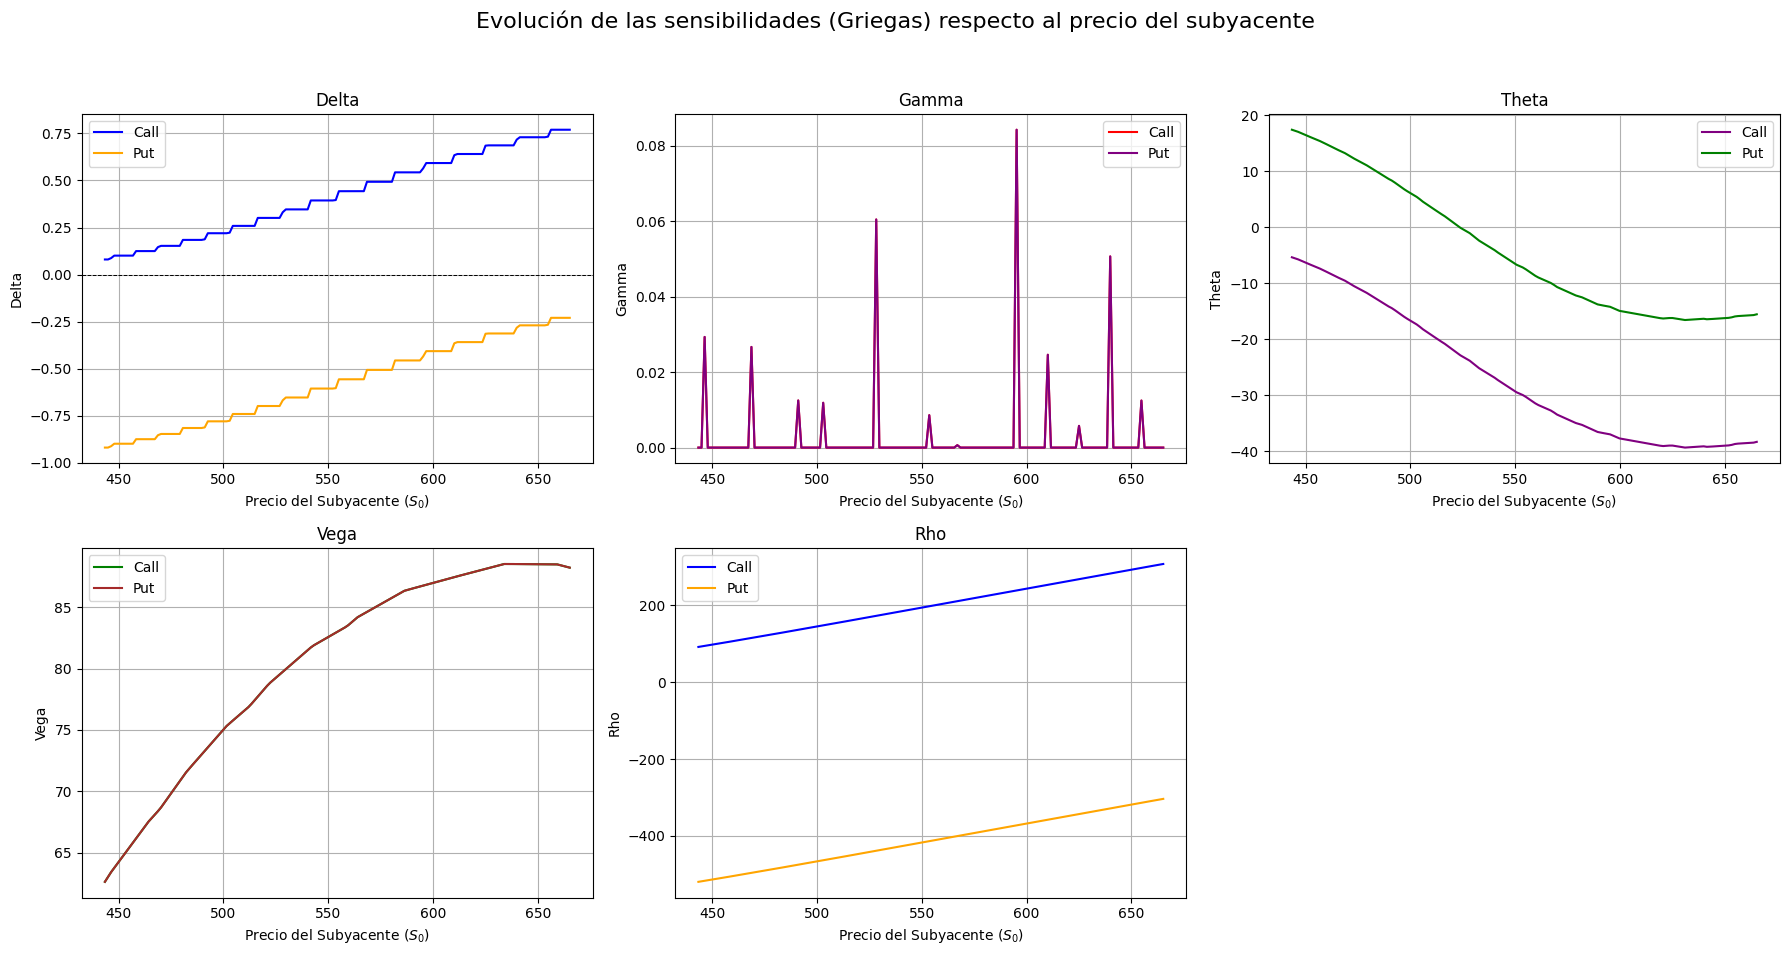

In [23]:
# Rango de precios del subyacente para evaluar
S_values = np.linspace(S0*0.8, S0*1.2, 150)

# Listas para almacenar valores
deltas_call, gammas_call, thetas_call, vegas_call, rhos_call = [], [], [], [], []
deltas_put, gammas_put, thetas_put, vegas_put, rhos_put = [], [], [], [], []

# Calcular griegas para cada precio del subyacente
for S in S_values:
    delta_c, gamma_c, theta_c, vega_c, rho_c = estimacion_griegas(S, K, T, r, sigma, N, tipo='call')
    delta_p, gamma_p, theta_p, vega_p, rho_p = estimacion_griegas(S, K, T, r, sigma, N, tipo='put')

    deltas_call.append(delta_c)
    gammas_call.append(gamma_c)
    thetas_call.append(theta_c)
    vegas_call.append(vega_c)
    rhos_call.append(rho_c)

    deltas_put.append(delta_p)
    gammas_put.append(gamma_p)
    thetas_put.append(theta_p)
    vegas_put.append(vega_p)
    rhos_put.append(rho_p)

# Crear figura grande con subplots 2x3 — hacemos 5 gráficas y dejamos 1 espacio vacío o reutilizamos
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Evolución de las sensibilidades (Griegas) respecto al precio del subyacente', fontsize=16)

# Delta
axs[0,0].plot(S_values, deltas_call, label='Call', color='blue')
axs[0,0].plot(S_values, deltas_put, label='Put', color='orange')
axs[0,0].set_title('Delta')
axs[0,0].set_xlabel('Precio del Subyacente ($S_0$)')
axs[0,0].set_ylabel('Delta')
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].axhline(0, color='black', linestyle='--', linewidth=0.7)

# Gamma
axs[0,1].plot(S_values, gammas_call, label='Call', color='red')
axs[0,1].plot(S_values, gammas_put, label='Put', color='purple')
axs[0,1].set_title('Gamma')
axs[0,1].set_xlabel('Precio del Subyacente ($S_0$)')
axs[0,1].set_ylabel('Gamma')
axs[0,1].grid(True)
axs[0,1].legend()

# Theta
axs[0,2].plot(S_values, thetas_call, label='Call', color='purple')
axs[0,2].plot(S_values, thetas_put, label='Put', color='green')
axs[0,2].set_title('Theta')
axs[0,2].set_xlabel('Precio del Subyacente ($S_0$)')
axs[0,2].set_ylabel('Theta')
axs[0,2].grid(True)
axs[0,2].legend()

# Vega
axs[1,0].plot(S_values, vegas_call, label='Call', color='green')
axs[1,0].plot(S_values, vegas_put, label='Put', color='brown')
axs[1,0].set_title('Vega')
axs[1,0].set_xlabel('Precio del Subyacente ($S_0$)')
axs[1,0].set_ylabel('Vega')
axs[1,0].grid(True)
axs[1,0].legend()

# Rho
axs[1,1].plot(S_values, rhos_call, label='Call', color='blue')
axs[1,1].plot(S_values, rhos_put, label='Put', color='orange')
axs[1,1].set_title('Rho')
axs[1,1].set_xlabel('Precio del Subyacente ($S_0$)')
axs[1,1].set_ylabel('Rho')
axs[1,1].grid(True)
axs[1,1].legend()

# Último subplot queda vacío o puedes dejarlo para otra gráfica o un texto
axs[1,2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Modelo Trinomial

A continuación se presentan resultados de construcción de árboles con el modelo trinomial

In [24]:
# Parámetros del ejemplo
N = 4        # Número de pasos

# Opción de compra (call)
call_prima_trin, arbol_suby_trin, arbol_call_trin = trinomial_eur(S, K, T, r, sigma, N, option='call')
print('Resultados Modelo Trinomial opción Call europea')
print(f'El árbol del subyacente es:')
print(f'{pd.DataFrame(arbol_suby_trin).fillna("-")}')
print()
print(f'El árbol de la opción Call Europea:')
print(f'{pd.DataFrame(arbol_call_trin).fillna("-")}')
print(f'La prima de la opción Call Europea es {call_prima_trin.round(2)} dólares')
print()

# Opción de venta (put)
put_prima_trin, arbol_suby_trin, arbol_put_trin = trinomial_eur(S, K, T, r, sigma, N, option='put')
print('Resultados Modelo Trinomial opción Put europea')
print(f'El árbol del subyacente es:')
print(f'{pd.DataFrame(arbol_suby_trin).fillna("-")}')
print()
print(f'El árbol de la opción Put Europea:')
print(f'{pd.DataFrame(arbol_put_trin).fillna("-")}')
print(f'La prima de la opción Put Europea es {put_prima_trin.round(2)} dólares')


Resultados Modelo Trinomial opción Call europea
El árbol del subyacente es:
            0           1           2           3            4
0  665.184009  760.916684  870.427119  995.698196  1138.998172
1    0.000000  665.184009  760.916684  870.427119   995.698196
2    0.000000  581.495681  665.184009  760.916684   870.427119
3    0.000000    0.000000  581.495681  665.184009   760.916684
4    0.000000    0.000000  508.336374  581.495681   665.184009
5    0.000000    0.000000    0.000000  508.336374   581.495681
6    0.000000    0.000000    0.000000  444.381407   508.336374
7    0.000000    0.000000    0.000000    0.000000   444.381407
8    0.000000    0.000000    0.000000    0.000000   388.472762

El árbol de la opción Call Europea:
           0           1           2           3           4
0  97.573839  171.919018  272.285985  391.779528  529.246164
1   0.000000   88.591840  164.259205  266.508451  385.946188
2   0.000000   34.472372   78.771467  156.998016  260.675111
3   0.000000 

### Comparación de resultados con los obtenidos por el modelo binomial y con Black-Scholes.

In [25]:
# Valoren opciones tipo call y put europeas para distintos strikes y vencimientos.
K_list = [0.9 * S0, S0, S0 * 1.1] # se crea una lista con 3 strikes
T_list = [0.25, 0.5, 0.75, 1] # se crea una lista con 2 vencimientos
N_list = [4, 12, 252] # se crea una lista con 3 valores para particiones o pasos en el árbol

# Se crea una lista vacia para almacenar los resultados de valorar opciones para diferentes strikes, vencimientos y pasos
resultados = []
inicio = time.time()

for T in T_list:
    for K in K_list:
        for N in N_list:
            # valoracion usando arbol binomial con modelo CRR
            call_bin_crr, stock_tree, call_tree = binomial_crr(S0, K, T, r, sigma, N, option='call')
            put_bin_crr, _, put_tree = binomial_crr(S0, K, T, r, sigma, N, option='put')
            # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
            paridad_b_crr = call_bin_crr - put_bin_crr - S0 + K * np.exp(-r * T)

            # valoracion usando arbol binomial con modelo Jarrow-Rudd
            call_bin_jr, stock_tree_jr, call_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='call')
            put_bin_jr, _, put_tree_jr = binomial_jr(S0, K, T, r, sigma, N, option='put')
            # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
            paridad_b_jr = call_bin_jr - put_bin_jr - S0 + K * np.exp(-r * T)

            # valoracion utilizando arbol trinomial.
            call_tr, stock_tree_tr, call_tree_tr = trinomial_eur(S0, K, T, r, sigma, N, option='call')
            put_tr, _, put_tree_tr = trinomial_eur(S0, K, T, r, sigma, N, option='put')
            # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
            paridad_b_jr = call_tr - put_tr - S0 + K * np.exp(-r * T)

            # valoracion utilizando la fórmula de Black-Scholes.
            call_bs = black_scholes(S0, K, T, r, sigma, option='call')
            put_bs = black_scholes(S0, K, T, r, sigma, option='put')
            # Paridad Call-Put: se verifica la siguiente expresión: C − P - S + Ke−rT = 0
            paridad_bs = call_bs - put_bs - S0 + K * np.exp(-r * T)

            # valoracion utilizando arbol trinomial.
            call_tr, stock_tree_tr, call_tree_tr = trinomial_eur(S0, K, T, r, sigma, N, option='call')
            put_tr, _, put_tree_tr = trinomial_eur(S0, K, T, r, sigma, N, option='put')

            resultados.append({
                'Strike': round(K, 2),
                'Vencimiento': T,
                'N': N,
                'Call CRR': round(call_bin_crr, 4),
                'Call Jarrow-Rudd': round(call_bin_jr, 4),
                'Call Black-Scholes': round(call_bs, 4),
                'Call Trinomial': round(call_tr, 4),

                'Put CRR': round(put_bin_crr, 4),
                'Put Jarrow-Rudd': round(put_bin_jr, 4),
                'Put Black-Scholes': round(put_bs, 4),
                'Put Trinomial': round(put_tr, 4)
            })

            #input("\nPresiona Enter para continuar...\n")

# Mostrar resultados
fin = time.time()
tabla = pd.DataFrame(resultados)
print(f"\nTiempo total de ejecución: {fin - inicio:.2f} segundos")
print("\nResumen de Resultados:")
tabla.sort_values(by='Strike')


Tiempo total de ejecución: 14.16 segundos

Resumen de Resultados:


,Strike,Vencimiento,N,Call CRR,Call Jarrow-Rudd,Call Black-Scholes,Call Trinomial,Put CRR,Put Jarrow-Rudd,Put Black-Scholes,Put Trinomial
0,498.89,0.25,4,62.4566,62.5705,62.9417,63.1531,2.2519,2.3658,2.7369,2.9484
1,498.89,0.25,12,62.8142,62.6713,62.9417,62.9820,2.6094,2.4665,2.7369,2.7772
2,498.89,0.25,252,62.9416,62.9409,62.9417,62.9446,2.7369,2.7362,2.7369,2.7399
9,498.89,0.50,4,72.1268,71.5727,71.6200,71.3361,7.1950,6.6409,6.6882,6.4043
10,498.89,0.50,12,71.8482,71.9191,71.6200,71.5264,6.9164,6.9873,6.6882,6.5946
11,498.89,0.50,252,71.6234,71.6199,71.6200,71.6215,6.6916,6.6881,6.6882,6.6897
18,498.89,0.75,4,80.9657,80.5397,79.5877,79.3630,11.3520,10.9260,9.9740,9.7494
19,498.89,0.75,12,79.3798,79.7509,79.5877,79.8168,9.7661,10.1373,9.9740,10.2031
27,498.89,1.00,4,88.7365,88.4795,86.9449,87.3341,14.4858,14.2288,12.6942,13.0834
20,498.89,0.75,252,79.5748,79.5898,79.5877,79.5886,9.9611,9.9761,9.9740,9.9749


### Ventajas y desventajas del modelo trinomial frente al binomial.

**Modelo Trinomial**

*Ventajas*

+ Incorpora mayor flexibilidad que el modelo binomial al representar tres posibles trayectorias del precio del activo (sube, baja o se mantiene), lo que permite una mejor adaptación a diferentes estados de la naturaleza.

+ Dada su mayor flexibilidad, podría ser más adecuado para mercados poco profundos o con poca liquidez, es decir, para activos que tienen poca negociación.

*Desventajas*

+ En mercados profundos y líquidos, es poco probable que el precio permanezca constante, lo que puede hacer que el estado de "precio se mantiene" sea poco probable.

+ La implementación es lativamente más compleja que el modelo binomial, lo que puede dificultar su comprensión y aplicación.

+ Costo Computacional Elevado: Requiere más cálculos y recursos computacionales, lo que puede ser un inconveniente en situaciones que requieren evaluaciones rápidas.

**Modelo Binomial**

*Ventajas*

+ En mercados profundos y líquidos, los activos están cambiando de precio constantemente, lo cual captura el modelo binomial con los dos posibles estados de la naturaleza: subir o bajar.

+ La implementación es relativamente menos compleja que el modelo trinomial, lo que puede ayudar en su comprensión y uso. Además, la menor complejidad está representada en una menor cantidad de cálculos.

*Desventajas*

+ Para mercados poco profundos el modelo binomial podría no capturar o representar la dinámica que presenten los precios de los activos. Por ejemplo, si el precio no cambia de un día para otro, el modelo binomial construiría un árbol del subyacente que no refleja el comportamiento del precio, lo cual podría ocasionar sesgos en la estimación del valor de la opción.